# Employee Salary Prediction

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
!pip install lightgbm
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/salary_prediction_data.csv")
df.columns = df.columns.str.strip()  # Clean extra spaces

# Preview the data
print(df.head())
print(df.info())


     Education  Experience  Location Job_Title  Age  Gender         Salary
0  High School           8     Urban   Manager   63    Male   84620.053665
1          PhD          11  Suburban  Director   59    Male  142591.255894
2     Bachelor          28  Suburban   Manager   61  Female   97800.255404
3  High School          29     Rural  Director   45    Male   96834.671282
4          PhD          25     Urban   Analyst   26  Female  132157.786175
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null   object 
 4   Age         1000 non-null   int64  
 5   Gender      1000 non-null   object 
 6   Salary      1000 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB
None


Load and Preprocess the Data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
df = pd.read_csv("salary_prediction_data.csv")

# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and Target
X = df.drop(columns=["Salary"], axis = 1)
y = df["Salary"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


 Train XGBoost Regressor

In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_pred = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)

print(f" XGBoost Regressor -> R2 Score: {xgb_r2:.4f}, MSE: {xgb_mse:.2f}")


 XGBoost Regressor -> R2 Score: 0.8390, MSE: 131432076.05


Train Random Forest Regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

print(f" Random Forest Regressor -> R2 Score: {rf_r2:.4f}, MSE: {rf_mse:.2f}")


 Random Forest Regressor -> R2 Score: 0.8442, MSE: 127209797.83


 Train LightGBM Model

In [7]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(verbosity=-1)  # Suppress LightGBM logs
model.fit(X_train, y_train)

import lightgbm as lgb
from sklearn.metrics import r2_score

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM -> R2 Score:", r2_score(y_test, y_pred_lgb))


LightGBM -> R2 Score: 0.8493548317405639


Train CatBoostRegressor Model

In [8]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Train CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")


R2 Score: 0.8504
MSE: 122112627.76


In [9]:
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize models
models = {
    "LightGBM": LGBMRegressor(verbosity=-1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

# Train, predict, and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    results[name] = {"R2": r2, "MSE": mse}
    print(f"{name} -> R2 Score: {r2:.4f}, MSE: {mse:.2f}")

# Find best model based on R2
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")
print(f"   R2 Score: {results[best_model_name]['R2']:.4f}")
print(f"   MSE: {results[best_model_name]['MSE']:.2f}")


LightGBM -> R2 Score: 0.8494, MSE: 123005780.34
CatBoost -> R2 Score: 0.8504, MSE: 122112627.76
XGBoost -> R2 Score: 0.8390, MSE: 131432076.05
Random Forest -> R2 Score: 0.8442, MSE: 127209797.83

✅ Best Model: CatBoost
   R2 Score: 0.8504
   MSE: 122112627.76


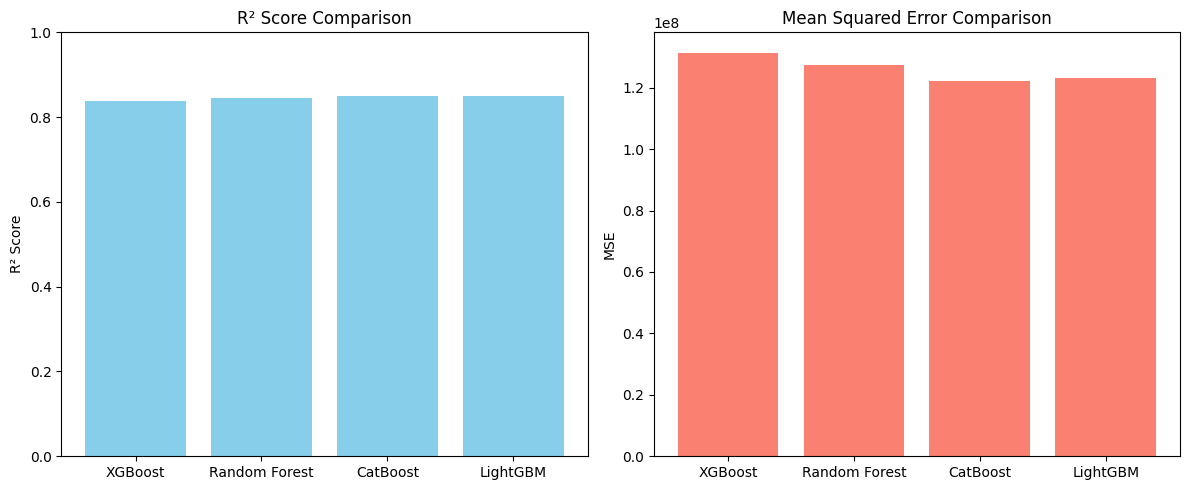


✅ Best Model: CatBoost
   R² Score: 0.8504
   MSE: 122112627.76


In [10]:
import matplotlib.pyplot as plt

results = {
    'XGBoost': {"R2": 0.8390, "MSE": 131432076.05},
    'Random Forest': {"R2": 0.8442, "MSE": 127209797.83},
    'CatBoost': {"R2": 0.8504, "MSE": 122112627.76},
    'LightGBM': {"R2": 0.8494, "MSE": 123005780.34}
}

# Extract data
models = list(results.keys())
r2_scores = [results[model]["R2"] for model in models]
mses = [results[model]["MSE"] for model in models]

# Plotting R² Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color='skyblue')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)

# Plotting MSE
plt.subplot(1, 2, 2)
plt.bar(models, mses, color='salmon')
plt.title("Mean Squared Error Comparison")
plt.ylabel("MSE")

plt.tight_layout()
plt.show()

# Print best model by R²
best_model = max(results.items(), key=lambda x: x[1]["R2"])
print(f"\n✅ Best Model: {best_model[0]}")
print(f"   R² Score: {best_model[1]['R2']}")
print(f"   MSE: {best_model[1]['MSE']}")


In [11]:
import joblib
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


models = {
    "LightGBM": LGBMRegressor(verbosity=-1, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

# Identify the best model name based on highest R2 (using the results dictionary from previous cells)
best_model_name = max(results, key=lambda x: results[x]["R2"])

# Get the best model object from the re-defined 'models' dictionary
best_model = models[best_model_name]

# Get the metrics for the best model (using the results dictionary from previous cells)
mse = results[best_model_name]["MSE"]
r2 = results[best_model_name]["R2"]

# Saving model, mse, and r2 together in a tuple
joblib.dump((best_model, mse, r2), "best_salary_model.pkl")
print(" Model saved as best_salary_model.pkl")

 Model saved as best_salary_model.pkl


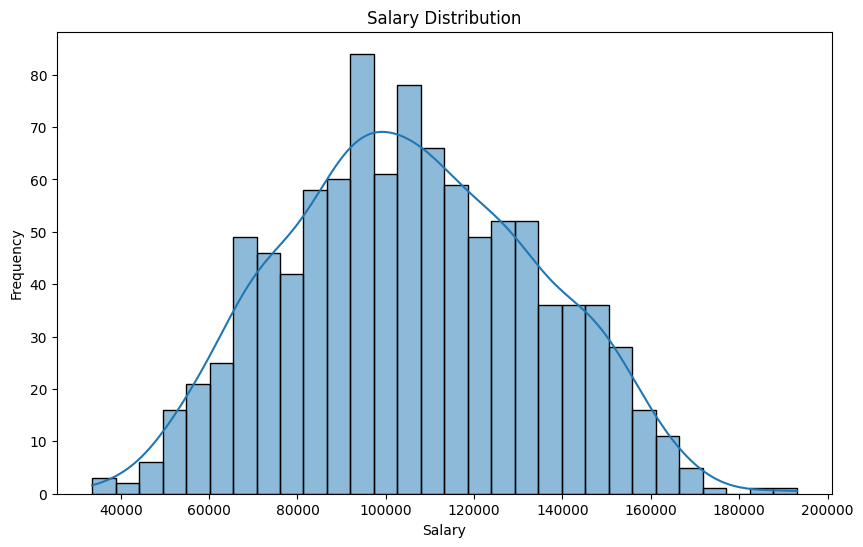

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/salary_prediction_data.csv")

# Plot salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["Salary"], kde=True, bins=30)
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.show()


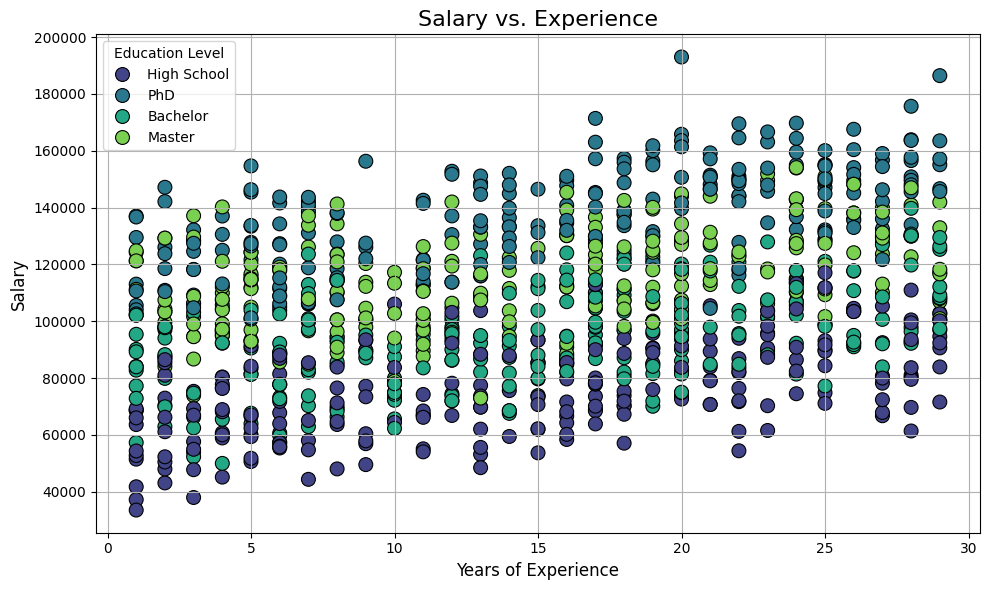

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("salary_prediction_data.csv")

# Plot: Salary vs. Experience
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Experience", y="Salary", hue="Education", palette="viridis", s=100, edgecolor="black")
plt.title("Salary vs. Experience", fontsize=16)
plt.xlabel("Years of Experience", fontsize=12)
plt.ylabel("Salary", fontsize=12)
plt.grid(True)
plt.legend(title="Education Level")
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import joblib

df = pd.read_csv("salary_prediction_data.csv")


X = df.drop(columns=["Salary"])
y = df["Salary"]

# Define categorical and numerical columns
categorical_features = ["Education", "Location", "Gender", "Job_Title"]
numerical_features = ["Age", "Experience"]


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", StandardScaler(), numerical_features)
])

# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", CatBoostRegressor(verbose=0, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "salary_prediction_pipeline.pkl")
print("✅ Pipeline trained and saved as 'salary_prediction_pipeline.pkl'")


sample_input = pd.DataFrame({
    "Education": ["Master"],
    "Age": [30],
    "Location": ["Urban"],
    "Gender": ["Female"],
    "Job_Title": ["Manager"],
    "Experience": [5]
})

prediction = pipeline.predict(sample_input)[0]
print(f"✅ Sample Prediction: ₹ {prediction:,.2f} per month")


✅ Pipeline trained and saved as 'salary_prediction_pipeline.pkl'
✅ Sample Prediction: ₹ 116,781.86 per month


In [15]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

# Load the saved pipeline
pipeline = joblib.load("salary_prediction_pipeline.pkl")

# Get predictions using the pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the pipeline's predictions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a DataFrame with the results for the best model
results_df = pd.DataFrame([["CatBoost (Pipeline)", round(mse, 2), round(r2, 4)]],
                          columns=["Model", "MSE", "R² Score"])

results_df.to_csv("model_evaluation.csv", index=False)

display(results_df)

,Model,MSE,R² Score
0,CatBoost (Pipeline),1.216285e+08,0.851


In [16]:
import numpy as np
import pandas as pd

# Load the saved pipeline
pipeline = joblib.load("salary_prediction_pipeline.pkl")

# Predict using best model
y_pred = pipeline.predict(X_test)

# Create comparison DataFrame
test_results = pd.DataFrame({
    'Actual Salary': y_test,
    'Predicted Salary (CatBoost)': y_pred,
})

# Calculate error percentage
test_results["Error %"] = np.abs((test_results["Actual Salary"] - test_results["Predicted Salary (CatBoost)"]) / test_results["Actual Salary"]) * 100

# Round values
test_results = test_results.round(2)

# Save to CSV
test_results.to_csv("sample_predictions.csv", index=False)

# Preview top 20 rows
print("✅ Showing test samples with error % using best model: CatBoost")
print(test_results[["Actual Salary", "Predicted Salary (CatBoost)", "Error %"]].head(20))

✅ Showing test samples with error % using best model: CatBoost
     Actual Salary  Predicted Salary (CatBoost)  Error %
521       86677.84                     76312.84    11.96
737       56036.16                     54254.25     3.18
740       92226.87                    110588.58    19.91
660      100710.09                    106115.90     5.37
411       91775.01                     97960.12     6.74
678       52282.49                     58129.45    11.18
626      102139.81                     95982.86     6.03
513      127491.15                    107092.21    16.00
859      117342.19                    122993.18     4.82
136       99647.04                    103693.67     4.06
811      166637.43                    158870.39     4.66
76       169510.25                    161903.67     4.49
636      100903.10                    110611.52     9.62
973       95395.50                     97858.21     2.58
938       94613.54                     94605.24     0.01
899      102512.10       

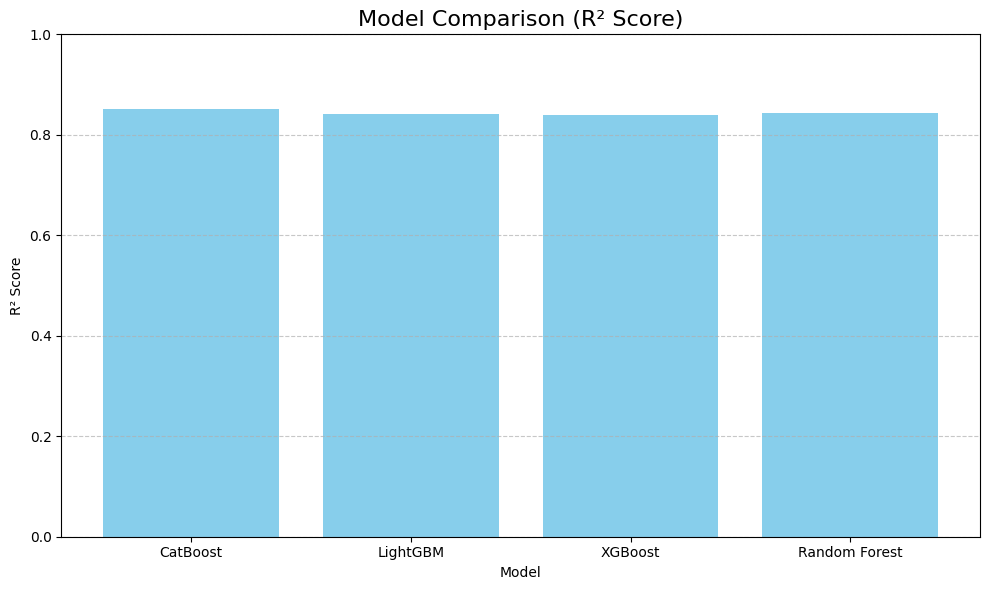

In [20]:
import matplotlib.pyplot as plt

# Existing model scores
model_scores = {
    "CatBoost": 0.8504,
    "LightGBM": 0.8409,
    "XGBoost": 0.8390,
    "Random Forest": 0.8442,
}
filtered_scores = {k: v for k, v in model_scores.items() if v > 0}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(filtered_scores.keys(), filtered_scores.values(), color='skyblue')
plt.title("Model Comparison (R² Score)", fontsize=16)
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
